In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as m
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error
from statistics import mean

In [2]:
data = pd.read_csv(r'A:\Academics\Semester 6\CS306\Project\Sept_20_analysis.csv')
data.head()

,GAME,BlackElo,BlackRatingDiff,Date,ECO,Event,Opening,Result,Site,Termination,...,Black_ts_blunders,White_ts_blunders,Black_ts_mistakes,White_ts_mistake,Black_long_moves,White_long_moves,Black_bad_long_moves,White_bad_long_moves,Game_flips,Game_flips_ts
0,11,1143,6.0,2020.09.01,A02,Rated Blitz game,Bird Opening,0-1,https://lichess.org/hjb8FYm1,Time forfeit,...,0,0,0,0,2,1,1,1,8,0
1,14,1504,NaN,2020.09.01,A04,Rated Blitz game,Réti Opening,0-1,https://lichess.org/Iz2fbHuE,Normal,...,0,0,0,0,0,1,0,0,6,0
2,29,1933,1.0,2020.09.01,C41,Rated Blitz game,Philidor Defense,0-1,https://lichess.org/Cdj7flmY,Time forfeit,...,0,0,0,0,1,1,1,0,5,0
3,40,1710,10.0,2020.09.01,B23,Rated Blitz game,Sicilian Defense: Closed,0-1,https://lichess.org/WZQ9FEpD,Normal,...,4,0,0,0,3,1,1,0,8,1
4,55,1598,-1.0,2020.09.01,B03,Rated Rapid game,Alekhine Defense,1-0,https://lichess.org/ESlJl57U,Normal,...,0,0,0,0,0,0,0,0,2,0


In [34]:
data.shape

(3739909, 40)

In [31]:
data_clean = data.dropna()

In [33]:
data_clean.shape

(3716475, 40)

Text(0.5, 1.0, 'Detecting outliers for BlackElo')

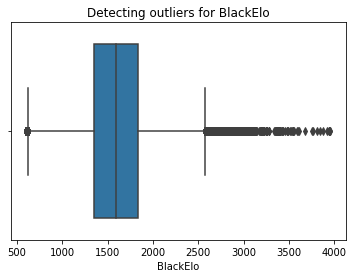

In [32]:
sns.boxplot(data_clean['BlackElo'])
plt.title('Detecting outliers for BlackElo')

In [35]:
Q1 = data_clean['BlackElo'].quantile(0.25)
Q3 = data_clean['BlackElo'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 
filter = (data_clean['BlackElo'] >= Q1 - 1.5 * IQR) & (data_clean['BlackElo'] <= Q3 + 1.5 *IQR)
data1 = data_clean.loc[filter]

In [36]:
data1.shape

(3704955, 40)

Text(0.5, 1.0, 'Detecting outliers for WhiteElo')

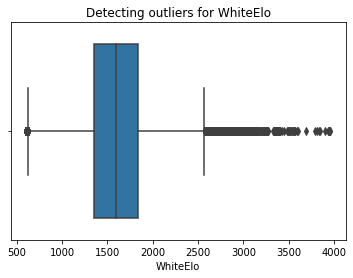

In [37]:
sns.boxplot(data['WhiteElo'])
plt.title('Detecting outliers for WhiteElo')

In [38]:
Q1 = data1['WhiteElo'].quantile(0.25)
Q3 = data1['WhiteElo'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 
filter = (data1['WhiteElo'] >= Q1 - 1.5 * IQR) & (data1['WhiteElo'] <= Q3 + 1.5 *IQR)
data1 = data1.loc[filter]

In [39]:
data1.shape

(3699349, 40)

In [40]:
black_elo = data1['BlackElo'].to_numpy()
black_elo = black_elo - np.mean(black_elo)
black_elo/=np.std(black_elo)

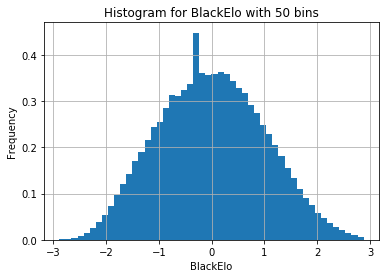

In [41]:
plt.hist(black_elo, bins = 50, density=True)
plt.xlabel('BlackElo')
plt.ylabel('Frequency')
plt.title('Histogram for BlackElo with 50 bins')
plt.grid()

In [42]:
white_elo = data1['WhiteElo'].to_numpy()
white_elo = white_elo - np.mean(white_elo)
white_elo/=np.std(white_elo)

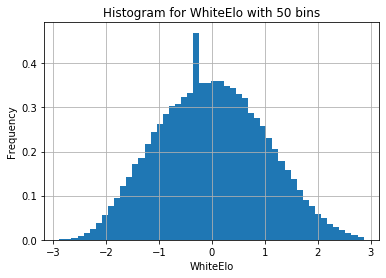

In [43]:
plt.hist(white_elo, bins = 50, density=True)
plt.xlabel('WhiteElo')
plt.ylabel('Frequency')
plt.title('Histogram for WhiteElo with 50 bins')
plt.grid()

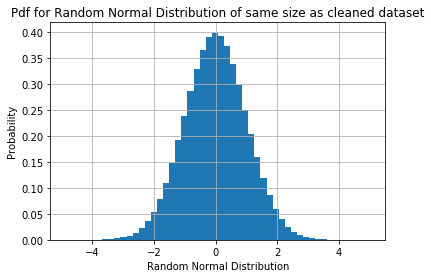

In [44]:
mu, sigma = 0, 1 # mean and standard deviation
normal_curve = np.random.normal(mu, sigma, black_elo.size)
plt.hist(normal_curve, bins = 50, density=True)
plt.xlabel('Random Normal Distribution')
plt.ylabel('Probability')
plt.title('Pdf for Random Normal Distribution of same size as cleaned dataset')
plt.grid()

In [45]:
from scipy.stats import ks_2samp
D_black, p_black = ks_2samp(normal_curve, black_elo)
print(D_black)

0.017345484300075487


In [46]:
D_white, p_white = ks_2samp(normal_curve, white_elo)
print(D_white)

0.019555873209043007


In [47]:
rhs = 1.073*np.sqrt(2/black_elo.shape[0]) # for confidence level alpha = 0.2, this is rejected
print(rhs)

0.0007889546992503149


In [48]:
alpha = 0.2
while D_black > np.sqrt(-np.log(alpha/2)/black_elo.shape[0]):
    alpha = alpha + 0.1
print("The hypothesis for black_elo to be gaussian is accepted at alpha level ", alpha)

The hypothesis for black_elo to be gaussian is accepted at alpha level  2.0000000000000004


C:\Users\mihir\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


In [49]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [50]:
all_scores = np.concatenate((data1['BlackElo'], data1['WhiteElo']), axis=None)
elo = (['black_elo'] * data1['BlackElo'].shape[0]) +  (['white_elo'] * data1['BlackElo'].shape[0])
data_anova = pd.DataFrame({'Variable': elo, 'Value': all_scores})
lm = ols('Value ~ Variable',data=data_anova).fit()
table  = sm.stats.anova_lm(lm)
print(table)

                 df        sum_sq       mean_sq         F   PR(>F)
Variable        1.0  1.089911e+06  1.089911e+06  9.558899  0.00199
Residual  7398696.0  8.436037e+11  1.140206e+05       NaN      NaN


In [30]:
all_scores = np.concatenate((data['BlackElo'], data['WhiteElo']), axis=None)
elo = (['black_elo'] * data['BlackElo'].shape[0]) +  (['white_elo'] * data['BlackElo'].shape[0])
data_anova = pd.DataFrame({'Variable': elo, 'Value': all_scores})
lm = ols('Value ~ Variable',data=data_anova).fit()
table  = sm.stats.anova_lm(lm)
print(table)

                 df        sum_sq       mean_sq         F    PR(>F)
Variable        1.0  1.160967e+06  1.160967e+06  9.834511  0.001713
Residual  7479816.0  8.829949e+11  1.180504e+05       NaN       NaN


# Clustering

In [147]:
data_c = data[data['ECO'] == 'A03']
data_c = data_c[data_c['TimeControl'] == '1800+0']

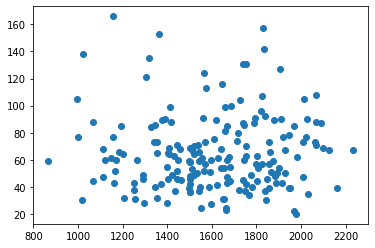

In [148]:
plt.scatter(data_c['BlackElo'], data_c['Total_moves'])

In [149]:
q1 = data_c['BlackElo'].to_numpy()
q2 = data_c['Total_moves'].to_numpy()
q1 = q1.reshape(1, -1)
q2 = q2.reshape(1, -1)
X = np.concatenate((q1, q2), axis=0)
X = X.T
print(X.shape)

(183, 2)


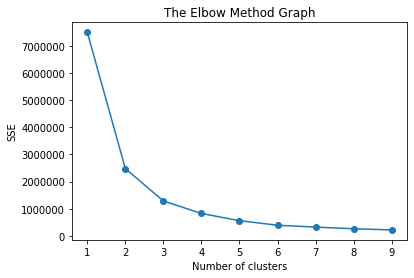

In [90]:
from sklearn.cluster import KMeans
K = range(1, 10)
sse = []
for k in K:
    kmeans = KMeans(n_clusters=k, max_iter=100, n_init=10, random_state=0)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

plt.plot(K,sse, 'o-')
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [150]:
kmeans = KMeans(n_clusters=3, max_iter=100, n_init=10, random_state=0) # 3 clusters
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

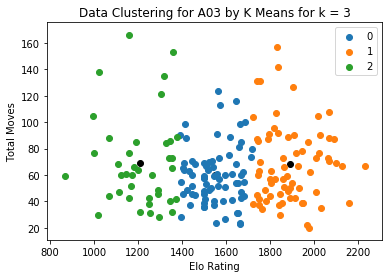

In [151]:
plt.figure()
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='black')
for g in np.unique(kmeans.labels_):
    j = np.where(kmeans.labels_ == g)
    plt.scatter(X[j, 0], X[j, 1], label=g)
plt.legend()
plt.title('Data Clustering for A03 by K Means for k = '+str(3))
plt.xlabel('Elo Rating')
plt.ylabel('Total Moves')
plt.show()

In [152]:
#print(kmeans.labels_)
print(np.where(kmeans.labels_ == 0)[0].shape)
print(np.where(kmeans.labels_ == 1)[0].shape)
print(np.where(kmeans.labels_ == 2)[0].shape)

(75,)
(69,)
(39,)


# Visualizations

Text(0, 0.5, 'Openings')

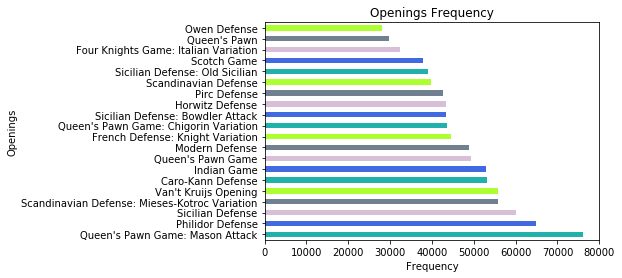

In [164]:
data['Opening'].value_counts().head(20).plot.barh(color=['lightseagreen', 'royalblue', 'thistle', 'slategrey', 'greenyellow'])
plt.title('Openings Frequency')
plt.xlabel('Frequency')
plt.ylabel('Openings')

In [165]:
white_won = data[data['Result'] == '1-0']

Text(0, 0.5, 'Openings')

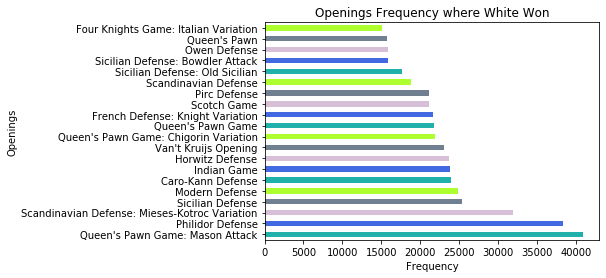

In [169]:
white_won['Opening'].value_counts().head(20).plot.barh(color=['lightseagreen', 'royalblue', 'thistle', 'slategrey', 'greenyellow'])
plt.title('Openings Frequency where White Won')
plt.xlabel('Frequency')
plt.ylabel('Openings')

In [167]:
black_won = data[data['Result'] == '0-1']

Text(0, 0.5, 'Openings')

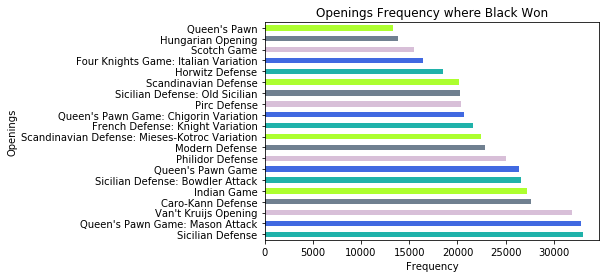

In [170]:
black_won['Opening'].value_counts().head(20).plot.barh(color=['lightseagreen', 'royalblue', 'thistle', 'slategrey', 'greenyellow'])
plt.title('Openings Frequency where Black Won')
plt.xlabel('Frequency')
plt.ylabel('Openings')